In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import datetime
from collections import namedtuple

from stable_baselines3.common.vec_env.subproc_vec_env import SubprocVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.utils import set_random_seed

from modular_baselines.loggers.basic import(InitLogCallback,
                                            LogRolloutCallback,
                                            LogWeightCallback,
                                            LogGradCallback,
                                            LogHyperparameters)

from modular_baselines.vca.algorithm import DiscreteStateVCA
from modular_baselines.vca.buffer import Buffer
from modular_baselines.vca.collector import NStepCollector
from modular_baselines.vca.modules import (CategoricalPolicyModule,
                                           FullCategoricalTransitionModule,
                                           CategoricalTransitionModule,
                                           MultiheadCatgoricalTransitionModule)
from environment import MazeEnv

In [2]:
now = datetime.datetime.now().strftime("%m-%d-%Y-%H-%M-%S")
args = dict(
    buffer_size = 10000,
    policy_hidden_size = 64,
    policy_tau = 1,
    transition_hidden_size = 32,
    transition_module_tau = 1,
    batchsize = 32,
    entropy_coef = 0.01,
    rollout_len=50,
    total_timesteps=int(5e4),
    device="cpu",
    log_interval=25,
    trans_lr=3e-2 * 0,
    policy_lr=3e-3,
    use_gumbel=False,
    grad_norm=False,
    pg_optimization=False,
    grad_clip=True,
    seed=None,
    log_dir="logs/{}".format(now)
)
if args["seed"] is None:
    args["seed"] = np.random.randint(0, 2**16)

In [3]:
args = namedtuple("Args", args.keys())(*args.values())
env = MazeEnv()

set_random_seed(args.seed)
vecenv = make_vec_env(lambda: MazeEnv(), seed=args.seed)

hyper_callback = LogHyperparameters(args._asdict())
rollout_callback = LogRolloutCallback()
init_callback = InitLogCallback(args.log_interval,
                                args.log_dir)
weight_callback = LogWeightCallback("weights.json")
grad_callback = LogGradCallback("grads.json")

buffer = Buffer(
    args.buffer_size,
    vecenv.observation_space,
    vecenv.action_space)

policy_m = CategoricalPolicyModule(
    vecenv.observation_space.n,
    vecenv.action_space.n,
    args.policy_hidden_size,
    tau=args.policy_tau,
    use_gumbel=args.use_gumbel)
trans_m = FullCategoricalTransitionModule(
    vecenv.observation_space.n,
    vecenv.action_space.n,
    state_set=torch.from_numpy(env.state_set),
    hidden_size=args.transition_hidden_size,
    tau=args.transition_module_tau,
    use_gumbel=args.use_gumbel)

collector = NStepCollector(
    env=vecenv,
    buffer=buffer,
    policy=policy_m,
    callbacks=[rollout_callback])
algorithm = DiscreteStateVCA(
    policy_module=policy_m,
    transition_module=trans_m,
    buffer=buffer,
    collector=collector,
    env=vecenv,
    reward_vals=env.expected_reward(),
    rollout_len=args.rollout_len,
    trans_opt=torch.optim.RMSprop(trans_m.parameters(), lr=args.trans_lr),
    policy_opt=torch.optim.RMSprop(policy_m.parameters(), lr=args.policy_lr),
    batch_size=args.batchsize,
    entropy_coef=args.entropy_coef,
    device=args.device,
    pg_optimization=args.pg_optimization,
    grad_clip=args.grad_clip,
    callbacks=[init_callback, weight_callback, grad_callback, hyper_callback]
)

Logging to logs/01-30-2021-20-07-26


/Users/tolga/anaconda/lib/python3.8/site-packages/pycolab/ascii_art.py:318: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  art = np.vstack(np.fromstring(line, dtype=np.uint8) for line in art)


In [4]:
from gymcolab.envs.simplemaze import SimpleMaze
from copy import deepcopy

ideal_logits = torch.zeros_like(algorithm.transition_module.logits)

env = MazeEnv()
state_map = env.state_map
init_world_map = ["##########",
                  "#      @ #",
                  "#        #",
                  "##### ####",
                  "#        #",
                  "#        #",
                  "##########"]

# init_world_map = ["################",
#                   "#    @         #",
#                   "#              #",
#                   "########   #####",
#                   "#              #",
#                   "#####     ######",
#                   "#              #",
#                   "#              #",
#                   "################"]

for (pos_y, pos_x), state_ix in state_map.items():
    world_map = deepcopy(init_world_map)
    row = list(world_map[pos_y])
    row[pos_x] = "P"
    world_map[pos_y] = "".join(row)

    for act_ix in range(env.action_space.n):
        maze_env = SimpleMaze(worldmap=world_map)
        maze_env.reset()
        player_pos = tuple(np.argwhere(maze_env.step(act_ix)[0][2] == 1)[0])
    
        ideal_logits[state_ix][act_ix][state_map[player_pos]] = 10

In [5]:
algorithm.transition_module.logits.data = ideal_logits
"Ideal Logits set"

'Ideal Logits set'

In [9]:
(algorithm.transition_module.logits.data == torch.from_numpy(env.get_ideal_logits()).float()).all()

tensor(True)

In [4]:
ideal_logits = torch.from_numpy(env.get_ideal_logits()).float()
algorithm.transition_module.logits.data = ideal_logits

In [6]:
algorithm.learn(args.total_timesteps)

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 32       |
|    ep_rew_mean     | 1        |
| time/              |          |
|    fps             | 1163     |
|    iterations      | 0        |
|    time_elapsed    | 0        |
|    total_timesteps | 50       |
| train/             |          |
|    Transition MSE  | 3        |
|    Transition loss | 0.00145  |
---------------------------------


/Users/tolga/Research/modular-baselines/modular_baselines/vca/algorithm.py:193: UserWarning: Using a target size (torch.Size([32, 33])) that is different to the input size (torch.Size([33])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  torch.nn.functional.mse_loss(


---------------------------------
| playback/          |          |
|    action_grad     | 0.0532   |
|    state_grad      | 0.0886   |
| rollout/           |          |
|    ep_len_mean     | 52.4     |
|    ep_rew_mean     | 0.889    |
| time/              |          |
|    fps             | 404      |
|    iterations      | 25       |
|    time_elapsed    | 3        |
|    total_timesteps | 1300     |
| train/             |          |
|    E[R]            | 0.84     |
|    Transition MSE  | 3        |
|    Transition loss | 0.00145  |
|    entropy         | 1.09     |
|    log_probs       | -88.5    |
---------------------------------
---------------------------------
| playback/          |          |
|    action_grad     | 0.0915   |
|    state_grad      | 0.0868   |
| rollout/           |          |
|    ep_len_mean     | 11.3     |
|    ep_rew_mean     | 1        |
| time/              |          |
|    fps             | 603      |
|    iterations      | 50       |
|    time_elap

---------------------------------
| playback/          |          |
|    action_grad     | 0.075    |
|    state_grad      | 0.0843   |
| rollout/           |          |
|    ep_len_mean     | 12.1     |
|    ep_rew_mean     | 1        |
| time/              |          |
|    fps             | 884      |
|    iterations      | 350      |
|    time_elapsed    | 19       |
|    total_timesteps | 17550    |
| train/             |          |
|    E[R]            | 1        |
|    Transition MSE  | 2.99     |
|    Transition loss | 0.00145  |
|    entropy         | 0.449    |
|    log_probs       | -4.96    |
---------------------------------
---------------------------------
| playback/          |          |
|    action_grad     | 0.0631   |
|    state_grad      | 0.0825   |
| rollout/           |          |
|    ep_len_mean     | 15.6     |
|    ep_rew_mean     | 1        |
| time/              |          |
|    fps             | 891      |
|    iterations      | 375      |
|    time_elap

---------------------------------
| playback/          |          |
|    action_grad     | 0.0728   |
|    state_grad      | 0.0846   |
| rollout/           |          |
|    ep_len_mean     | 12.6     |
|    ep_rew_mean     | 1        |
| time/              |          |
|    fps             | 897      |
|    iterations      | 675      |
|    time_elapsed    | 37       |
|    total_timesteps | 33800    |
| train/             |          |
|    E[R]            | 1        |
|    Transition MSE  | 2.99     |
|    Transition loss | 0.00145  |
|    entropy         | 0.482    |
|    log_probs       | -5.61    |
---------------------------------
---------------------------------
| playback/          |          |
|    action_grad     | 0.0751   |
|    state_grad      | 0.0834   |
| rollout/           |          |
|    ep_len_mean     | 12.2     |
|    ep_rew_mean     | 1        |
| time/              |          |
|    fps             | 907      |
|    iterations      | 700      |
|    time_elap

In [8]:
from visualizers.visualize import render_layout

render_layout(
    log_dir="logs/{}".format(now),
    layout=[["S", "S"], ["H", "H"]]
)

\sum r_t

In [ ]:
path = "static/policy_m2.b"
import os

os.makedirs("static", exist_ok=True)
with open(path, "wb") as bin_file:
    torch.save(algorithm.policy_module.state_dict(), bin_file)


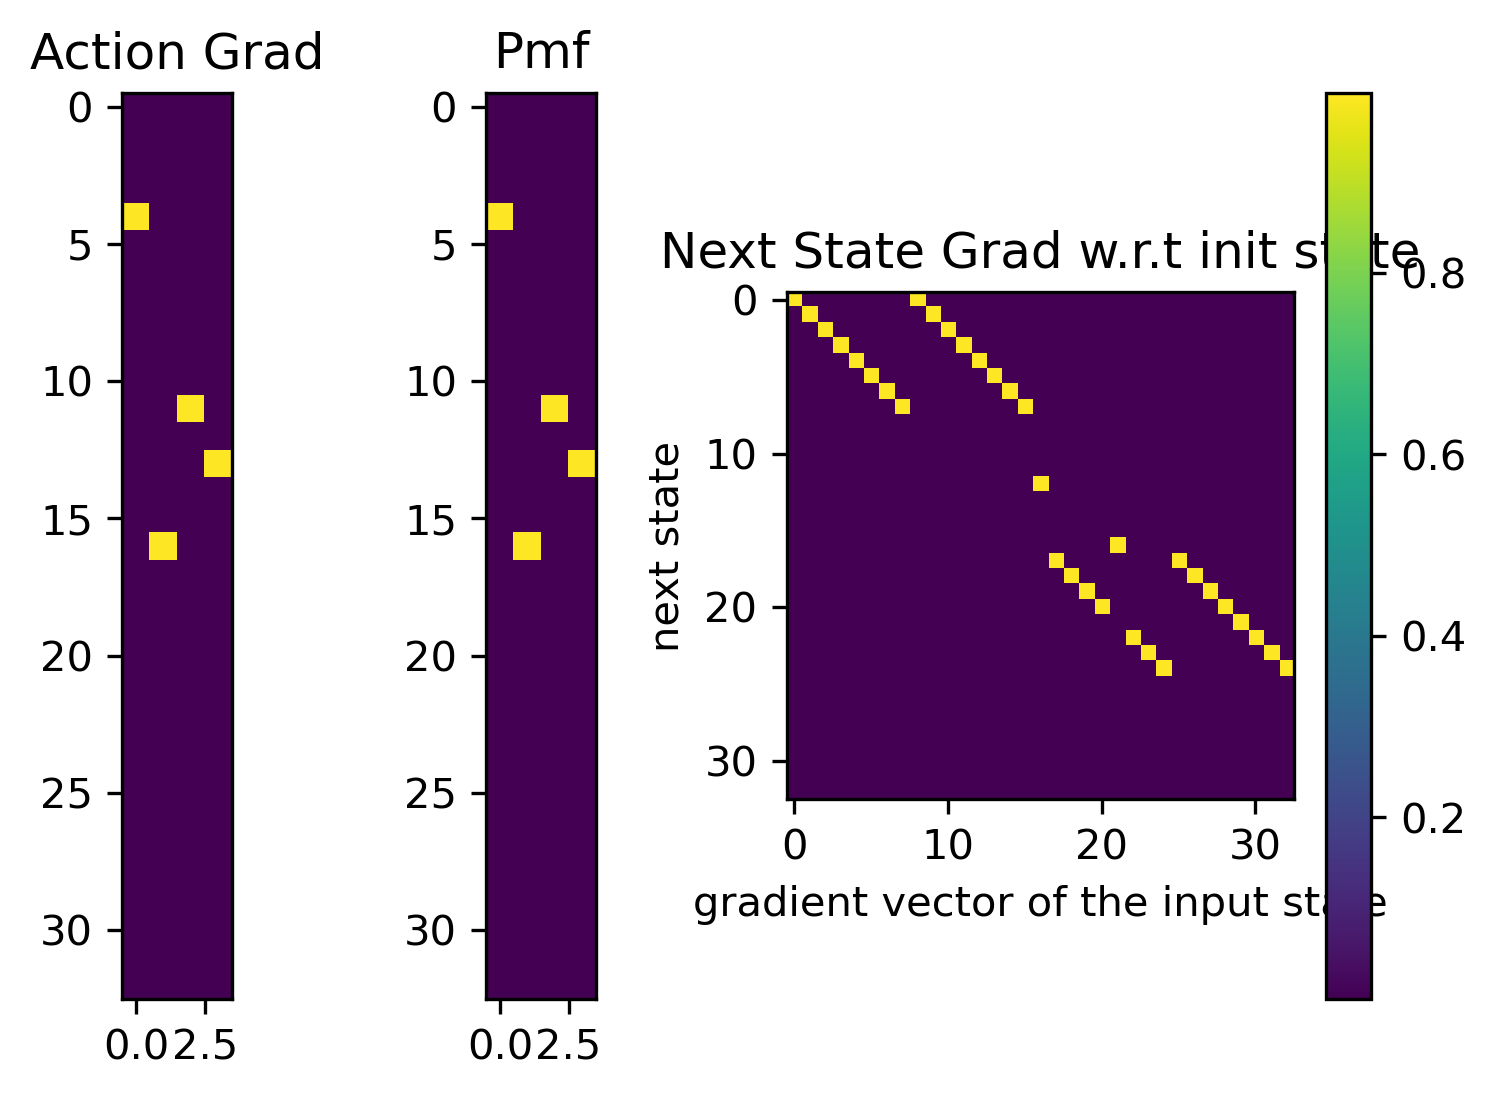

In [5]:
import matplotlib.pyplot as plt


def one_step_grad(init_state=12):
    jac_act = torch.zeros((4, env.observation_space.n, 4))
    jac_state = torch.zeros((4, env.observation_space.n, env.observation_space.n))
    
    r_state = (torch.ones((4, 1)) * init_state) == torch.arange(env.observation_space.n).reshape(1, -1)
    r_state = r_state.float()
    r_state.requires_grad = True
    r_state.retain_grad()
    
    action = torch.arange(4, requires_grad=False)
    r_action = algorithm._action_onehot(action.reshape(4, 1))
    r_action.requires_grad = True
    r_action.retain_grad()
    
    probs = algorithm.transition_module.dist(r_state, r_action)
    probs.retain_grad()

    for ix in range(env.observation_space.n):
        
        probs[:, ix].backward(torch.ones(4), retain_graph=True)
        jac_act[:, ix, :] = r_action.grad
        r_action.grad.zero_()
        
        jac_state[:, ix, :] = r_state.grad
        r_state.grad.zero_()
        
    return jac_act, jac_state, probs.detach().numpy().T

jax, jac_state, pmf = one_step_grad()

plt.figure(dpi=300)
plt.subplot(141)
plt.imshow(jax[0])
plt.title("Action Grad")
# plt.colorbar()

plt.subplot(142)
plt.imshow(pmf)
plt.title("Pmf")
# plt.colorbar()

plt.subplot(122)
plt.imshow(jac_state[0])
plt.title("Next State Grad w.r.t init state")
plt.ylabel("next state")
plt.xlabel("gradient vector of the input state")
plt.colorbar()


/Users/tolga/anaconda/lib/python3.8/site-packages/pycolab/ascii_art.py:318: FutureWarning:

arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.



tensor([[7.9705e-07, 7.9474e-07, 8.0172e-07, 1.0091e-05],
        [1.0091e-05, 2.4399e-05, 7.9773e-07, 2.4369e-05],
        [8.0463e-07, 8.0042e-07, 8.0319e-07, 1.0091e-05],
        [7.9541e-07, 7.9983e-07, 8.0982e-07, 1.0091e-05],
        [1.0091e-05, 8.9605e-07, 7.9809e-07, 2.4368e-05],
        [1.0082e-05, 9.0185e-07, 2.4411e-05, 2.4374e-05],
        [7.6847e-06, 2.4377e-05, 1.0064e-05, 1.0102e-05],
        [7.6736e-06, 7.6778e-06, 1.0054e-05, 1.0084e-05],
        [7.6556e-06, 7.6689e-06, 1.0042e-05, 1.0071e-05],
        [1.0017e-05, 1.0028e-05, 1.1471e-05, 7.6618e-06],
        [1.0098e-05, 1.1162e-05, 1.3360e-05, 1.0001e-05],
        [7.1786e-06, 8.4198e-06, 9.4372e-06, 7.7248e-06],
        [5.5996e-06, 6.0296e-06, 5.4572e-06, 4.4586e-06],
        [3.9299e-06, 4.3601e-06, 3.5041e-06, 4.1813e-06],
        [2.2592e-06, 1.4893e-06, 2.4159e-06, 1.5302e-06],
        [1.5645e-06, 1.4870e-06, 1.5872e-06, 1.5275e-06],
        [1.8644e-07, 1.2759e-06, 1.1469e-06, 6.9750e-07]])

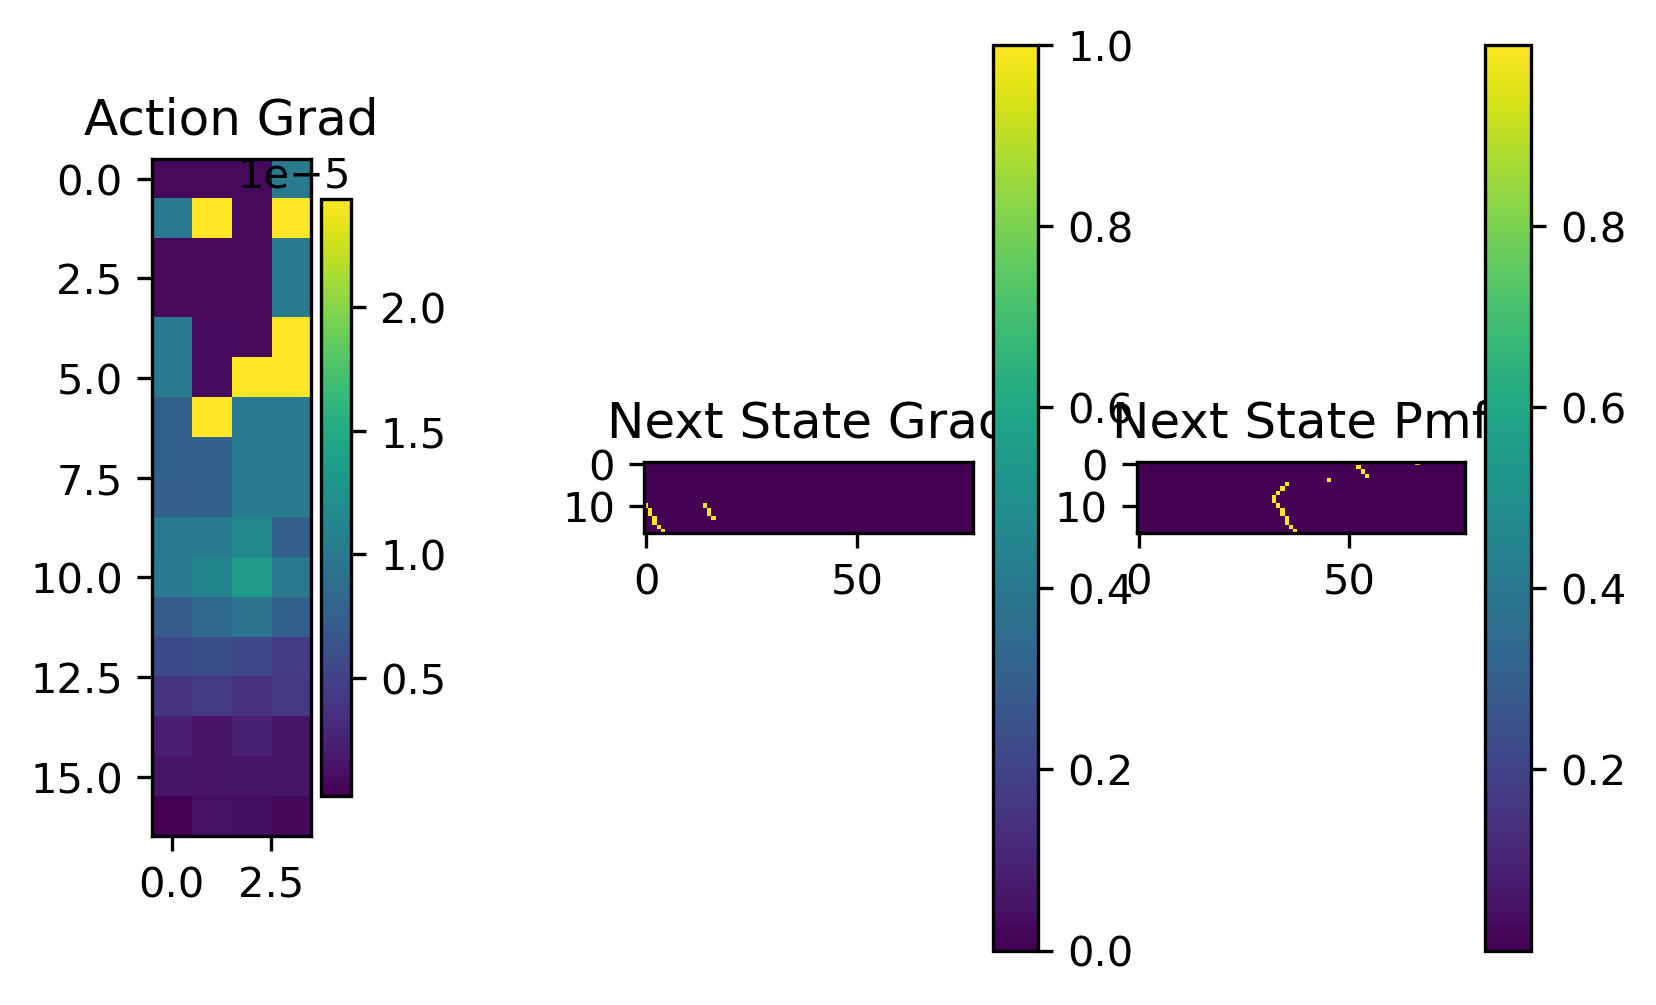

In [8]:
import matplotlib.pyplot as plt
from modular_baselines.vca.algorithm import GradNormalizer


# algorithm.transition_module.logits.data = ideal_logits
# trajectory_act = [3, 0, 3, 3, 0, 0, 0, 3, 3]
# trajectory_act = [3, 0, 3, 3, 0, 0, 2, 3, 0, 3, 3]
trajectory_act = [3, 0, 3, 3, 0, 0, 2, 2, 2, 0, 3, 3, 1, 3, 0, 3, 3]

def make_onehot_state(state):
    return ((torch.ones((1, 1)) * state) == torch.arange(env.observation_space.n).reshape(1, -1)).float()

def episode_grad(seed=1221, random_act=False):
    r_state_list = []
    r_action_list = []
    prob_list = []
    logprob_list = []
    reward_list = []
    iteration = 0
    
    reward_tens = torch.from_numpy(env.expected_reward())
    done = False
    env.action_space.seed(seed)
    
    state = env.reset()
    r_state = make_onehot_state(state)
    r_state = r_state.float()
    r_state.requires_grad = True
    r_state.retain_grad()
    
    while not done:
        
        
        if random_act:
            action = env.action_space.sample()
            r_action = torch.tensor(action)
        else:
            action = algorithm.policy_module(r_state)
            r_action = action.detach()
            if iteration == len(trajectory_act):
                break
            r_action = torch.tensor(trajectory_act[iteration])
        
        next_state, _, done, _ = env.step(r_action)
        next_state = make_onehot_state(next_state)
        
        r_action = (r_action.float().reshape(1, 1) == torch.arange(env.action_space.n).reshape(1, -1)).float()
        r_action.requires_grad = True
        r_action.retain_grad()
        r_action_list.append(r_action)
        
#         r_state = GradNormalizer.apply(r_state)
    
        probs = algorithm.transition_module.dist(r_state, r_action)
        prob_list.append(probs.detach())
        r_next_state = algorithm.transition_module.reparam(next_state, probs)
        r_next_state.retain_grad()
        r_state_list.append(r_next_state)

        reward_list.append((reward_tens * r_next_state).sum())
        r_state = r_next_state
        iteration += 1

#     sum(reward_list).backward()
    reward_list[-1].backward()
    return r_action_list, r_state_list, prob_list

actions, states, pmfs = episode_grad()
eps_acts_grad = torch.cat(list(map(lambda act: act.grad, actions)), dim=0)
eps_state_grad = torch.cat(list(map(lambda state: state.grad, states)), dim=0)
eps_pmfs = torch.cat(pmfs, dim=0)


plt.figure(dpi=300)
# print(eps_acts_grad)
plt.subplot(161)
plt.imshow(eps_acts_grad)
plt.title("Action Grad")
plt.colorbar()

# print(eps_acts_grad)
plt.subplot(132)
plt.imshow(eps_state_grad)
plt.title("Next State Grad")
plt.colorbar()

# print(eps_acts_grad)
plt.subplot(133)
plt.imshow(eps_pmfs)
plt.title("Next State Pmf")
plt.colorbar()

eps_acts_grad

In [ ]:
plt.figure(dpi=100)

state_pmf = torch.nn.functional.softmax(algorithm.transition_module.logits, dim=-1)
plt.imshow(state_pmf[:, 1].detach().numpy())


In [ ]:
%load_ext autoreload
%autoreload 2

from visualizers.scalarvis import MultiScalarRender

MultiScalarRender("logs/01-12-2021-22-30-12/01-12-2021-22-30-12")()

# Meeting Notes
- Gradient convergence comparison with PG and VCA
- PG running with the same trajectories & Full PG runs
- DQN & PPO ramPong

In [ ]:
_list_x = [1, 2, 3]
[(x, ix) for ix, x in reversed(list(enumerate(_list_x)))]
# [(x, ix) for ix, x in enumerate(reversed(_list_x))]

In [7]:
env.observation_space.n

78